In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_io as tfio
from IPython.display import Audio
import os
import pathlib

In [2]:
# default dataset pathing for easier reference
data_dir = pathlib.Path('kaggle_data/musicnet/musicnet/')

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:,-1])

In [5]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [6]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [7]:
# Full Wavenet implementation
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [8]:
# Simplified Model as written in HoML book
# model = keras.models.Sequential()
# model.add(keras.layers.InputLayer(input_shape=[None,1]))
# for rate in (1,2,4,8) * 2:
#     model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
#                                  activation="relu", dilation_rate=rate))
# model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
# model.compile(loss="mse", optimizer="adam", metrics = [last_time_step_mse])

In [9]:
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])

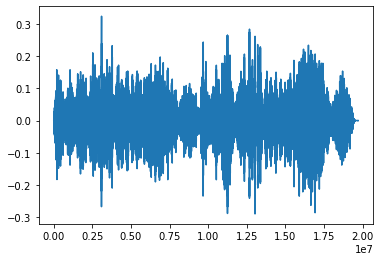

In [10]:
# using base tensorflow
audio_binary = tf.io.read_file('kaggle_data/musicnet/musicnet/train_data/1727.wav')
waveform = tfio.audio.decode_wav(audio_binary, dtype=tf.float32)
plt.plot(waveform)

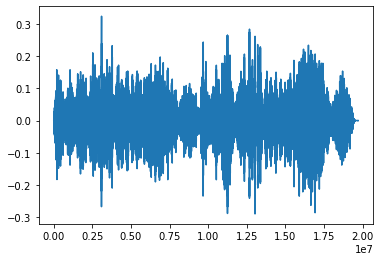

In [11]:
# using tfio package
audio_binary = tfio.audio.AudioIOTensor('kaggle_data/musicnet/musicnet/train_data/1727.wav')
waveform = audio_binary.to_tensor().numpy()
plt.plot(waveform)

In [12]:
len(waveform)

19715328

In [13]:
zero_label = pd.read_csv('kaggle_data/musicnet/musicnet/train_labels/1727.csv')

In [14]:
len(zero_label)

6580

In [15]:
composers = pd.read_csv('kaggle_data/musicnet_metadata.csv')

In [16]:
composers

,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
2,1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444
3,1730,Schubert,Piano Quintet in A major,5. Allegro giusto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,368
4,1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,Museopen,Segundo G. Yogore,D959,546
...,...,...,...,...,...,...,...,...,...
325,2632,Beethoven,Piano Sonata No 10 in G major,2. Andante,Solo Piano,Paul Pitman,piano-midi.de,OP14NO2,341
326,2633,Beethoven,Piano Sonata No 10 in G major,3. Scherzo: Allegro assai,Solo Piano,Paul Pitman,piano-midi.de,OP14NO2,227
327,2659,Bach,Violin Partita No 1 in B minor,6. Double,Solo Violin,John Garner,suzumidi,BWV1002,108
328,2677,Beethoven,Piano Sonata No 9 in E major,1. Allegro,Solo Piano,Paul Pitman,piano-midi.de,OP14NO1,445


In [17]:
#Audio(filename='kaggle_data/musicnet/musicnet/train_data/2677.wav')

In [29]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    return files_ds

In [19]:
training_names = tf.io.gfile.glob(str(data_dir) + '/train_data/*')
label_names = tf.io.gfile.glob(str(data_dir) + '/train_labels/*')

In [55]:
#training_names

In [31]:
training_ds = preprocess_dataset(training_names)

In [53]:
training_ds.as_numpy_iterator().next()

b'kaggle_data/musicnet/musicnet/train_data/1755.wav'

In [44]:
def decode_audio(audio_binary):
    audio, tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [45]:
tf.strings.split('kaggle_data/musicnet/musicnet/train_data/', os.path.sep)[-2]

<tf.Tensor: shape=(), dtype=string, numpy=b'train_data'>

In [22]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

In [24]:
wav_ds = tfio.audio.AudioIODataset('kaggle_data/musicnet/musicnet/train_data/1727.wav')

In [26]:
wav_tensor = tfio.audio.AudioIOTensor('kaggle_data/musicnet/musicnet/train_data/1727.wav')

In [33]:
model.fit(training_ds)

ValueError: in user code:

    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer conv1d is incompatible with the layer: : expected min_ndim=3, found ndim=0. Full shape received: ()
